In [1]:
! git clone "https://github.com/baalaji1206/Fuzzy_dataset.git"

Cloning into 'Fuzzy_dataset'...
remote: Enumerating objects: 1407, done.
remote: Total 1407 (delta 0), reused 0 (delta 0), pack-reused 1407
Receiving objects: 100% (1407/1407), 124.17 MiB | 29.95 MiB/s, done.
Updating files: 100% (1407/1407), done.


In [2]:
import os
import cv2
from tqdm import tqdm
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from keras.utils import to_categorical

In [3]:
labels = ['high', 'medium', 'low']

X_train = []
y_train = []
image_size = 160

root_folder = '/content/Fuzzy_dataset/split dataset dermnet/'
for class_folder in ['acne', 'actinic', 'atopic', 'lupus']:
    for label in labels:
        folder_path = os.path.join(root_folder, class_folder, label)
        for image_name in tqdm(os.listdir(folder_path)):
            img = cv2.imread(os.path.join(folder_path, image_name))
            img = cv2.resize(img, (image_size, image_size))
            X_train.append(img)
            y_train.append(label)

100%|██████████| 248/248 [00:01<00:00, 197.16it/s]


Fuzzy Rules

In [4]:
def fuzzy_severity(pixel_count):
    print("Intensity Red :", pixel_count)
    if pixel_count > 0 and pixel_count < 134:
        return "Low"
    elif pixel_count > 134 and pixel_count < 165:
        return "Medium"
    else:
        return "High"

Histogram Plot

In [5]:
import matplotlib.pyplot as plt

def assess_severity(max_pixel_count_r):
    severity_r = fuzzy_severity(max_pixel_count_r)

    return severity_r

for i, image in enumerate(X_train):
    r_channel, _, _ = cv2.split(image)
    r_hist = cv2.calcHist([r_channel], [0], None, [256], [0, 256])
    max_intensity_r = np.argmax(r_hist)
    severity = assess_severity(max_intensity_r)
    print(f"Image {i + 1}: Estimated Severity based on RGB Histogram - {severity}")

Intensity Red : 167
Image 1: Estimated Severity based on RGB Histogram - High
Intensity Red : 178
Image 2: Estimated Severity based on RGB Histogram - High
Intensity Red : 153
Image 3: Estimated Severity based on RGB Histogram - Medium
Intensity Red : 134
Image 4: Estimated Severity based on RGB Histogram - High
Intensity Red : 160
Image 5: Estimated Severity based on RGB Histogram - Medium
Intensity Red : 128
Image 6: Estimated Severity based on RGB Histogram - Low
Intensity Red : 139
Image 7: Estimated Severity based on RGB Histogram - Medium
Intensity Red : 127
Image 8: Estimated Severity based on RGB Histogram - Low
Intensity Red : 145
Image 9: Estimated Severity based on RGB Histogram - Medium
Intensity Red : 147
Image 10: Estimated Severity based on RGB Histogram - Medium
Intensity Red : 139
Image 11: Estimated Severity based on RGB Histogram - Medium
Intensity Red : 128
Image 12: Estimated Severity based on RGB Histogram - Low
Intensity Red : 134
Image 13: Estimated Severity bas

In [6]:
num_classes = len(labels)
x_train, x_test, y_train, y_test = train_test_split(X_train,y_train,test_size = 0.2, random_state = 101)

Label Encoder

In [7]:
le = LabelEncoder()
categories = labels
le.fit(categories)
y_train = le.transform(y_train)
y_test = le.transform(y_test)

In [8]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from keras.utils import to_categorical

y_train1=np.array(y_train)
y_test1=np.array(y_test)
train_Y_one_hot = to_categorical(y_train1)
test_Y_one_hot = to_categorical(y_test)


x_train2 = np.zeros((len(x_train),160,160,3),dtype='uint8')
for i in range(0,len(x_train)):
        x_train2[i,:,:,:]=x_train[i]
x_test2=np.zeros((len(x_test),160,160,3),dtype='uint8')
for i in range(0,len(x_test)):
        x_test2[i,:,:,:]=x_test[i]


In [9]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,BatchNormalization,Dropout
from tensorflow.keras.losses import CategoricalCrossentropy

VGG 16 Model

In [10]:
def create_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(160, 160, 3))

    model = Sequential()
    model.add(base_model)
    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))


    for layer in base_model.layers:
        layer.trainable = False

    from keras.optimizers import Adam
    custom_optimizer = Adam(learning_rate=0.01)
    model.compile(optimizer= custom_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model


Load Data

In [11]:
def load_data():

     y_train1=np.array(y_train)
     y_test1=np.array(y_test)

     train_Y_one_hot = to_categorical(y_train1)
     test_Y_one_hot = to_categorical(y_test)


     x_train2=np.zeros((len(x_train),160,160,3),dtype='uint8')
     for i in range(0,len(x_train)):
             x_train2[i,:,:,:]=x_train[i]

     x_test2=np.zeros((len(x_test),160,160,3),dtype='uint8')
     for i in range(0,len(x_test)):
             x_test2[i,:,:,:]=x_test[i]

     return x_train2, y_train1, x_test2, y_test1



In [12]:
from keras.preprocessing.image import ImageDataGenerator

Federated Averaging Momentum

In [13]:
def federated_averaging_with_momentum(global_model, client_models, momentum=0.9):
    # Aggregate model weights with momentum
    average_weights = []
    for layer in range(len(global_model.get_weights())):
        momentum_term = 0.0
        for client in client_models:
            client_weights = client.get_weights()[layer]
            momentum_term += momentum * (client_weights - global_model.get_weights()[layer])
        average_weights.append(global_model.get_weights()[layer] + momentum_term / len(client_models))
    global_model.set_weights(average_weights)


Federated Learning

In [14]:
def federated_learning(num_clients=10, num_epochs=5):
    global_model = create_model()
    x_train, y_train, x_test, y_test = load_data()
    client_data_size = len(x_train2) // num_clients

    client_models = [create_model() for _ in range(num_clients)]
    client_accuracies = []
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    datagen.fit(x_train2)

    overall_history = {'loss': [], 'accuracy': []}
    
    for client_id in range(num_clients):
        test_loss, test_acc = client_models[client_id].evaluate(x_test2, y_test1, verbose=0)
        client_accuracies.append(test_acc)
        print(f"Client {client_id + 1} (Before Training): Accuracy = {test_acc:.4f}")

    for client_id in range(num_clients):
        start_idx = client_id * client_data_size
        end_idx = start_idx + client_data_size
        x_local, y_local = x_train2[start_idx:end_idx], y_train1[start_idx:end_idx]

        history = client_models[client_id].fit(x_local, y_local, epochs=num_epochs,batch_size = 64, verbose=1)

        test_loss, test_acc = client_models[client_id].evaluate(x_test2, y_test1, verbose=0)
        print(f"Client {client_id + 1}: Accuracy = {test_acc:.4f}, Loss = {test_loss:.4f}")

    print("Client Accuracies (Before Training):", client_accuracies)


    federated_averaging_with_momentum(global_model,client_models,momentum=0.9)
    test_loss, test_acc = global_model.evaluate(x_test2, y_test1)
    train_loss, train_acc = global_model.evaluate(x_train2, y_train1)
    return global_model



In [15]:
global_model=federated_learning(num_clients=3,num_epochs=20)

58889256/58889256 [==============================] - 0s 0us/step
Client 1 (Before Training): Accuracy = 0.3688
Client 2 (Before Training): Accuracy = 0.2518
Client 3 (Before Training): Accuracy = 0.5390
Epoch 1/20
6/6 [==============================] - 17s 1s/step - loss: 1.2764 - accuracy: 0.5893
Epoch 2/20
6/6 [==============================] - 1s 118ms/step - loss: 0.4593 - accuracy: 0.8560
Epoch 3/20
6/6 [==============================] - 1s 119ms/step - loss: 0.3317 - accuracy: 0.9013
Epoch 4/20
6/6 [==============================] - 1s 118ms/step - loss: 0.2619 - accuracy: 0.8987
Epoch 5/20
6/6 [==============================] - 1s 118ms/step - loss: 0.2310 - accuracy: 0.9067
Epoch 6/20
6/6 [==============================] - 1s 118ms/step - loss: 0.1525 - accuracy: 0.9573
Epoch 7/20
6/6 [==============================] - 1s 118ms/step - loss: 0.1164 - accuracy: 0.9440
Epoch 8/20
6/6 [==============================] - 1s 118ms/step - loss: 0.0941 - accuracy: 0.9680
Epoch 9/20
6/6 

Severity Estimation


9/9 [==============================] - 1s 72ms/step


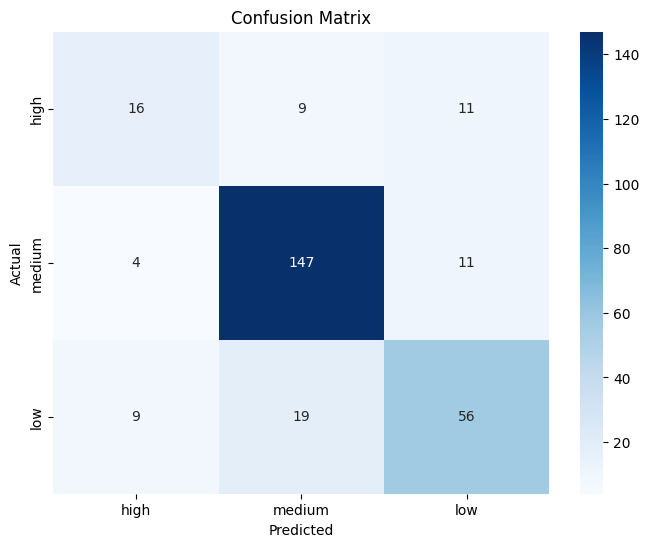

In [16]:
def generate_confusion_matrix(model, x_data, y_data, labels):
    predictions = model.predict(x_data)
    y_pred = np.argmax(predictions, axis=1)
    cm = confusion_matrix(y_data, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


generate_confusion_matrix(global_model, x_test2, y_test1, labels)


In [17]:
from sklearn.metrics import classification_report

def evaluate_metrics(model, x_data, y_data, labels):
    predictions = model.predict(x_data)
    y_pred = np.argmax(predictions, axis=1)
    report = classification_report(y_data, y_pred, target_names=labels)
    print("Classification Report:\n", report)


evaluate_metrics(global_model, x_test2, y_test1, labels)


9/9 [==============================] - 1s 70ms/step
Classification Report:
               precision    recall  f1-score   support

        high       0.55      0.44      0.49        36
      medium       0.84      0.91      0.87       162
         low       0.72      0.67      0.69        84

    accuracy                           0.78       282
   macro avg       0.70      0.67      0.69       282
weighted avg       0.77      0.78      0.77       282



In [18]:
def predict_skin_condition(image_path, global_model):
    image = cv2.imread(image_path)

    if image is not None:
        r_channel, _, _ = cv2.split(image)
        r_hist = cv2.calcHist([r_channel], [0], None, [256], [0, 256])
        max_intensity_r = np.argmax(r_hist)
        severity = assess_severity(max_intensity_r)

        input_single_image = cv2.resize(image, (image_size, image_size))
        input_single_image = np.expand_dims(input_single_image, axis=0)
        predicted = global_model.predict(input_single_image)
        predicted_label = labels[np.argmax(predicted)]
        print("Predicted Skin Condition:", severity)

    else:
        print("Error loading image")

image_path = '/content/Fuzzy_dataset/split dataset dermnet/atopic/low/03ichthyosis030127.jpg'
predict_skin_condition(image_path, global_model)

Intensity Red : 14
1/1 [==============================] - 1s 955ms/step
Predicted Skin Condition: Low
